In [15]:
%matplotlib notebook
import cvxpy as cp
import dccp
import torch
import numpy as np
from cvxpylayers.torch import CvxpyLayer
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn import svm
from sklearn.metrics import zero_one_loss, confusion_matrix
from scipy.io import arff
import pandas as pd
import time
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.datasets import make_classification
from sklearn.utils import shuffle
import matplotlib.patches as mpatches
import json
import random
import math
import os, psutil
from datetime import datetime
import pickle

torch.set_default_dtype(torch.float64)
torch.manual_seed(0)
np.random.seed(0)

XDIM = 2
TRAIN_SLOPE = 1
EVAL_SLOPE = 5
COST = 1./XDIM
X_LOWER_BOUND = -10
X_UPPER_BOUND = 10

C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Utils

In [17]:
def split_data(X, Y, percentage):
    num_val = int(len(X)*percentage)
    return X[num_val:], Y[num_val:], X[:num_val], Y[:num_val]

def shuffle(X, Y):
    data = torch.cat((X, Y), 1)
    data = data[torch.randperm(data.size()[0])]
    X = data[:, :2]
    Y = data[:, 2]
    return X, Y

def conf_mat(Y1, Y2):
    num_of_samples = len(Y1)
    mat = confusion_matrix(Y1, Y2, labels=[-1, 1])*100/num_of_samples
    acc = np.trace(mat)
    return mat, acc

def calc_accuracy(Y, Ypred):
    num = len(Y)
    temp = Y - Ypred
    acc = len(temp[temp == 0])*1./num
    return acc

# Dataset

In [18]:
def gen_custom_normal_data(N, pos_mean, pos_std, neg_mean, neg_std):
    torch.manual_seed(0)
    np.random.seed(0)
    pos_samples_num = N//2
    neg_samples_num = N - pos_samples_num
    posX = torch.randn((pos_samples_num, XDIM))*pos_std + pos_mean
    negX = torch.randn((neg_samples_num, XDIM))*neg_std + neg_mean
    
    X = torch.cat((posX, negX), 0)
    Y = torch.unsqueeze(torch.cat((torch.ones(len(posX)), -torch.ones(len(negX))), 0), 1)

    X, Y = shuffle(X, Y)
    return X, Y

# CCP classes

In [19]:
class CCP:
    def __init__(self, x_dim, funcs):
        self.f_derivative = funcs["f_derivative"]
        self.g = funcs["g"]
        self.c = funcs["c"]
        
        self.x = cp.Variable(x_dim)
        self.xt = cp.Parameter(x_dim)
        self.r = cp.Parameter(x_dim)
        self.w = cp.Parameter(x_dim)
        self.b = cp.Parameter(1)
        self.slope = cp.Parameter(1)
        self.v = cp.Parameter(x_dim)

        target = self.x@self.f_derivative(self.xt, self.w, self.b, self.slope)-self.g(self.x, self.w, self.b, self.slope)-self.c(self.x, self.r, self.v)
        constraints = [self.x >= X_LOWER_BOUND,
                       self.x <= X_UPPER_BOUND]
        self.prob = cp.Problem(cp.Maximize(target), constraints)
        
    def ccp(self, r):
        """
        numpy to numpy
        """
        self.xt.value = r
        self.r.value = r
        result = self.prob.solve()
        diff = np.linalg.norm(self.xt.value - self.x.value)
        cnt = 0
        while diff > 0.0001 and cnt < 10:
            cnt += 1
            self.xt.value = self.x.value
            result = self.prob.solve()
            diff = np.linalg.norm(self.x.value - self.xt.value)
        return self.x.value
    
    def optimize_X(self, X, w, b, slope, v):
        """
        tensor to tensor
        """
        w = w.detach().numpy()
        b = b.detach().numpy()
        v = v.detach().numpy()
        slope = np.full(1, slope)
        X = X.numpy()
        
        self.w.value = w
        self.b.value = b
        self.slope.value = slope
        self.v.value = v
        
        return torch.stack([torch.from_numpy(self.ccp(x)) for x in X])

In [20]:
class DELTA():
    
    def __init__(self, x_dim, funcs):
        self.g = funcs["g"]
        self.c = funcs["c_dpp_form"]
        
        self.x = cp.Variable(x_dim)
        self.w = cp.Parameter(x_dim, value = np.random.randn(x_dim))
        self.b = cp.Parameter(1, value = np.random.randn(1))
        self.v = cp.Parameter(x_dim, value = np.random.randn(x_dim), nonneg=True)
        self.rv = cp.Parameter(x_dim, value = np.random.randn(x_dim)) # r times v
        self.r2v = cp.Parameter(x_dim, value = np.random.randn(x_dim)) # r squared times v
        self.f_der = cp.Parameter(x_dim, value = np.random.randn(x_dim))

        target = self.x@self.f_der-self.g(self.x, self.w, self.b, TRAIN_SLOPE)-self.c(self.x, self.v, self.rv, self.r2v)
        constraints = [self.x >= X_LOWER_BOUND,
                       self.x <= X_UPPER_BOUND]
        objective = cp.Maximize(target)
        problem = cp.Problem(objective, constraints)
        self.layer = CvxpyLayer(problem, parameters=[self.w, self.b, self.v, self.rv, self.r2v, self.f_der],
                                variables=[self.x])
        
    def optimize_X(self, X, w, b, v, F_DER):
        rv = X*v
        r2v = (X**2)*v
        return self.layer(w, b, v, rv, r2v, F_DER)[0]

# Gain & Cost functions

In [21]:
def score(x, w, b):
    return x@w + b

def f(x, w, b, slope):
    return 0.5*cp.norm(cp.hstack([1, (slope*score(x, w, b) + 1)]), 2)

def g(x, w, b, slope):
    return 0.5*cp.norm(cp.hstack([1, (slope*score(x, w, b) - 1)]), 2)

def c(x, r, v):
    return COST*(((x-r)**2)@cp.abs(v))

def c_dpp_form(x, v, rv, r2v):
    return COST*cp.sum(cp.multiply(cp.square(x), v) - 2*cp.multiply(x, rv) + r2v)

def f_derivative(x, w, b, slope):
    return 0.5*cp.multiply(slope*((slope*score(x, w, b) + 1)/cp.sqrt((slope*score(x, w, b) + 1)**2 + 1)), w)

funcs = {"f": f, "g": g, "f_derivative": f_derivative, "c": c, "c_dpp_form": c_dpp_form, "score": score}

# Model

In [22]:
class MyStrategicModel(torch.nn.Module):
    def __init__(self, x_dim, funcs, train_slope, eval_slope, v_0, v_true, strategic=False, robust=False):
        torch.manual_seed(0)
        np.random.seed(0)
    
        super(MyStrategicModel, self).__init__()
        self.x_dim = x_dim
        self.train_slope, self.eval_slope = train_slope, eval_slope
        self.strategic = strategic
        self.robust = robust
        
        self.w = torch.nn.parameter.Parameter(math.sqrt(1/x_dim)*(1-2*torch.rand(x_dim, dtype=torch.float64, requires_grad=True)))
        self.b = torch.nn.parameter.Parameter(torch.rand(1, dtype=torch.float64, requires_grad=True))
        self.v_true = v_true
        self.v_0 = v_0
        if self.robust:
            self.V = torch.stack([self.v_0 + 1.7, self.v_0 - 1.7])
        else:
            self.V = torch.stack([self.v_0])
        
        self.ccp = CCP(x_dim, funcs)
        self.delta = DELTA(x_dim, funcs)
        
    def forward(self, X, evaluation=False):
        outputs = torch.zeros((self.V.size()[0], X.size()[0]))
        for i, v in enumerate(self.V):
            if self.strategic:
                if evaluation:
                    XT = self.ccp.optimize_X(X, self.w, self.b, self.eval_slope, torch.abs(v))
                    X_opt = XT
                else:
                    XT = self.ccp.optimize_X(X, self.w, self.b, self.train_slope, torch.abs(v))
                    F_DER = self.get_f_ders(XT, self.train_slope)
                    X_opt = self.delta.optimize_X(X, self.w, self.b, torch.abs(v), F_DER) # Xopt should equal to XT but we do it again for the gradients
                output = self.score(X_opt)
            else:
                output = self.score(X) 
            outputs[i] = output
        return outputs
    
    def optimize_X(self, X):
        return self.ccp.optimize_X(X, self.w, self.b, self.eval_slope, self.v_true)
    
    def score(self, x):
        return x@self.w + self.b
    
    def get_f_ders(self, XT, slope):
        return torch.stack([0.5*slope*((slope*self.score(xt) + 1)/torch.sqrt((slope*self.score(xt) + 1)**2 + 1))*self.w for xt in XT])

    def calc_accuracy(self, Y, Y_pred):
        Y_pred = torch.sign(torch.mean(torch.sign(Y_pred), 0))
        Y_pred[Y_pred == 0] = -Y[Y_pred == 0]
        num = len(Y)
        temp = Y - Y_pred
        acc = len(temp[temp == 0])*1./num        
        return acc
    
    def evaluate(self, X, Y):      
        return self.calc_accuracy(Y, self.forward(X, evaluation=True))
    
    def loss(self, Y, Y_pred):
        return torch.max(torch.mean(torch.clamp(1 - Y_pred * Y, min=0), 1))
    
    def save_model(self, train_errors, val_errors, train_losses, val_losses, info, path, comment=None):
        if comment is not None:
            path += "/" + comment
            
        filename = path + "/model.pt"
        if not os.path.exists(os.path.dirname(filename)):
            os.makedirs(os.path.dirname(filename))
        torch.save(self.state_dict(), filename)
        
        pd.DataFrame(self.V.detach().numpy()).to_csv(path + '/V.csv')
        pd.DataFrame(self.v_0.detach().numpy()).to_csv(path + '/v_0.csv')
        pd.DataFrame(self.v_true.detach().numpy()).to_csv(path + '/v_true.csv')
        
        pd.DataFrame(np.array(train_errors)).to_csv(path + '/train_errors.csv')
        pd.DataFrame(np.array(val_errors)).to_csv(path + '/val_errors.csv')
        pd.DataFrame(np.array(train_losses)).to_csv(path + '/train_losses.csv')
        pd.DataFrame(np.array(val_losses)).to_csv(path + '/val_losses.csv')
        
        with open(path + "/info.txt", "w") as f:
            f.write(info)
    
    def load_model(self, filename):
        self.load_state_dict(torch.load(filename))
        self.eval()
    
    def fit(self, path, X, Y, Xval, Yval, opt, opt_kwargs={"lr":1e-3}, batch_size=128, epochs=100, verbose=False, callback=None, comment=None):
        train_dset = TensorDataset(X, Y)
        train_loader = DataLoader(train_dset, batch_size=batch_size, shuffle=True)
        opt = opt(self.parameters(), **opt_kwargs)

        train_losses = []
        val_losses = []
        train_errors = []
        val_errors = []
        
        best_val_error = 1
        consecutive_no_improvement = 0

        total_time = time.time()
        for epoch in range(epochs):
            t1 = time.time()
            batch = 1
            train_losses.append([])
            train_errors.append([])
            for Xbatch, Ybatch in train_loader:
#                 try:
                opt.zero_grad()
                Ybatch_pred = self.forward(Xbatch)
                l = self.loss(Ybatch, Ybatch_pred)
                l.backward()
                opt.step()
                train_losses[-1].append(l.item())
                with torch.no_grad():
                    e = self.calc_accuracy(Ybatch, Ybatch_pred)
                    train_errors[-1].append(1-e)
                if verbose:
                    print("batch %03d / %03d | loss: %3.5f | err: %3.5f" %
                          (batch, len(train_loader), np.mean(train_losses[-1]), np.mean(train_errors[-1])))
                batch += 1
                if callback is not None:
                    callback()
#                 except:
#                     print("failed")
                
            with torch.no_grad():
                try:
                    Yval_pred = self.forward(Xval, evaluation=True)
                    val_loss = self.loss(Yval, Yval_pred).item()
                    val_losses.append(val_loss)
                    val_error = 1-self.calc_accuracy(Yval, Yval_pred)
                    val_errors.append(val_error)
                    if val_error < best_val_error:
                        consecutive_no_improvement = 0
                        best_val_error = val_error
                        info = "training time in seconds: {}\nepoch: {}\nbatch size: {}\ntrain slope: {}\neval slope: {}\nlearning rate: {}\nvalidation loss: {}\nvalidation error: {}\n".format(
                        time.time()-total_time, epoch, batch_size, self.train_slope, self.eval_slope, opt_kwargs["lr"], val_loss, val_error)
                        self.save_model(train_errors, val_errors, train_losses, val_losses, info, path, comment)
                        print("model saved!")

                    else:
                        consecutive_no_improvement += 1
                        if consecutive_no_improvement >= 4:
                            break
                except:
                    print("failed")
                    
            t2 = time.time()
            if verbose:
                print("------------- epoch %03d / %03d | time: %03d sec | loss: %3.5f | err: %3.5f" % (epoch + 1, epochs, t2-t1, val_losses[-1], val_errors[-1]))
        print("training time: {} seconds".format(time.time()-total_time)) 
        return train_errors, val_errors, train_losses, val_losses

# Data generation

percent of positive samples: 52.77777777777778%


<IPython.core.display.Javascript object>


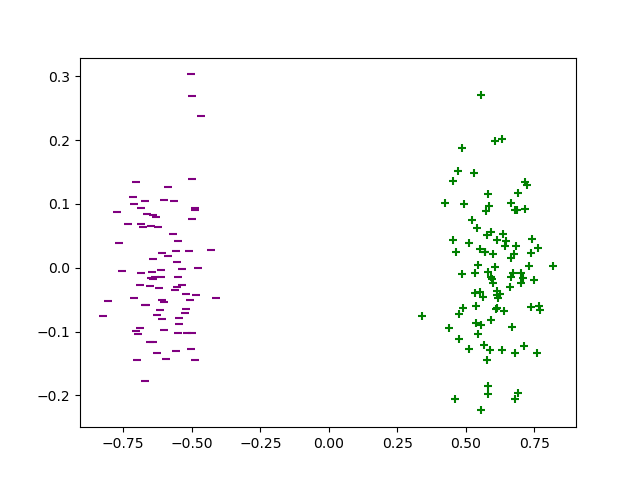

<IPython.core.display.Javascript object>


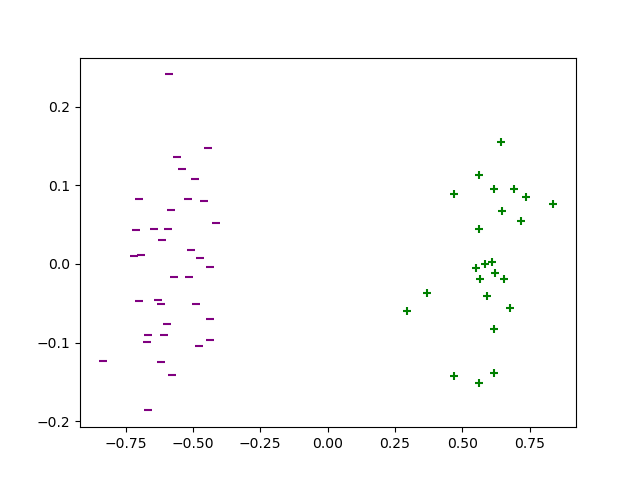

<IPython.core.display.Javascript object>


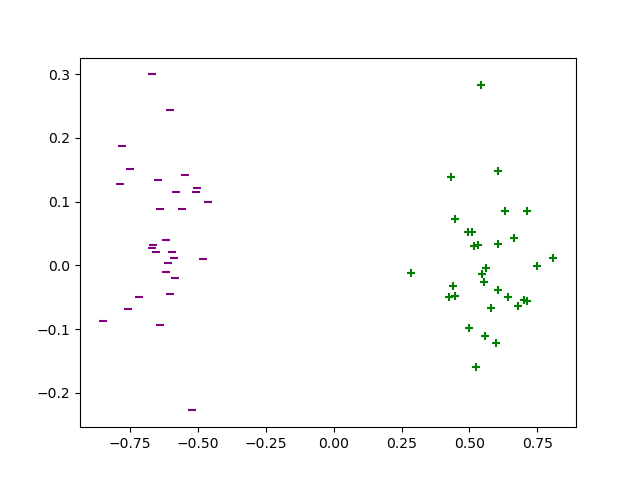

In [10]:
path = "./models/robustness"

N = 300
X, Y = gen_custom_normal_data(N, torch.Tensor([0.6, 0]), torch.Tensor([0.1, 0.1]), torch.Tensor([-0.6, 0]), torch.Tensor([0.1, 0.1]))

assert(len(X[0]) == XDIM)
X, Y, Xval, Yval = split_data(X, Y, 0.4)
Xval, Yval, Xtest, Ytest = split_data(Xval, Yval, 0.5)

print("percent of positive samples: {}%".format(100 * len(Y[Y == 1]) / len(Y)))

# Train

In [12]:
EPOCHS = 6
BATCH_SIZE = 16

x_dim = XDIM
v_true = torch.Tensor([0.5, 0.5])
v_0 = torch.Tensor([2, 2])


# non-strategic classification
print("---------- training non-strategically----------")
non_strategic_model = MyStrategicModel(x_dim, funcs, TRAIN_SLOPE, EVAL_SLOPE, v_0, v_true, strategic=False, robust=False)

non_strategic_model.fit(path, X, Y, Xval, Yval,
                                opt=torch.optim.Adam, opt_kwargs={"lr": (1e-1)},
                                batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=True, 
                                comment="non_strategic")

# strategic classification, fixed
print("---------- training strategically----------")
strategic_model_oracle = MyStrategicModel(x_dim, funcs, TRAIN_SLOPE, EVAL_SLOPE, v_true, v_true, strategic=True, robust=False)

strategic_model_oracle.fit(path, X, Y, Xval, Yval,
                                opt=torch.optim.Adam, opt_kwargs={"lr": (1e-1)},
                                batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=True,
                                comment="oracle")

# strategic classification, flexible
print("---------- training strategically----------")
strategic_model_robust = MyStrategicModel(x_dim, funcs, TRAIN_SLOPE, EVAL_SLOPE, v_0, v_true, strategic=True, robust=True)

strategic_model_robust.fit(path, X, Y, Xval, Yval,
                                opt=torch.optim.Adam, opt_kwargs={"lr": (1e-1)},
                                batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=True,
                                comment="robust")

# strategic classification, fixed
print("---------- training strategically----------")
strategic_model_fragile = MyStrategicModel(x_dim, funcs, TRAIN_SLOPE, EVAL_SLOPE, v_0, v_true, strategic=True, robust=False)

strategic_model_fragile.fit(path, X, Y, Xval, Yval,
                                opt=torch.optim.Adam, opt_kwargs={"lr": (1e-1)},
                                batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=True,
                                comment="fragile")